#참고  
[깃허브](https://github.com/akinoriosamura/nailtracking)

In [95]:
import tensorflow as tf
import numpy as np
import cv2
from imutils.video import WebcamVideoStream
import find_finger as ff
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
args = {
    "model": "/content/frozen_inference_graph.pb",
    # "model":"/media/todd/38714CA0C89E958E/147/yl_tmp/readingbook/model/export_model_015/frozen_inference_graph.pb",
    "labels": "./record/classes.pbtxt",
    # "labels":"record/classes.pbtxt" ,
    "num_classes": 1,
    "min_confidence": 0.6,
    "class_model": "../model/class_model/p_class_model_1552620432_.h5"}

COLORS = np.random.uniform(0, 255, size=(args["num_classes"], 3))

if __name__ == '__main__':
    model = tf.Graph()

    with model.as_default():
        print("> ====== loading NAIL frozen graph into memory")
        graphDef = tf.compat.v1.GraphDef()

        with tf.compat.v2.io.gfile.GFile(args["model"], "rb") as f:
            serializedGraph = f.read()
            graphDef.ParseFromString(serializedGraph)
            tf.import_graph_def(graphDef, name="")
        # sess = tf.Session(graph=graphDef)
        print(">  ====== NAIL Inference graph loaded.")
        # return graphDef, sess

    with model.as_default():
        with tf.compat.v1.Session(graph=model) as sess:
            imageTensor = model.get_tensor_by_name("image_tensor:0")
            boxesTensor = model.get_tensor_by_name("detection_boxes:0")

            # for each bounding box we would like to know the score
            # (i.e., probability) and class label
            scoresTensor = model.get_tensor_by_name("detection_scores:0")
            classesTensor = model.get_tensor_by_name("detection_classes:0")
            numDetections = model.get_tensor_by_name("num_detections:0")
            drawboxes = []
            # cap = cv2.VideoCapture(url)
            #vs = WebcamVideoStream(src=0)
            video="000.mp4"
            vs=cv2.VideoCapture(video)    
            #vs.start()
            while True:
                ret,frame = vs.read()
                if frame is None:
                    continue
                frame = cv2.flip(frame, 1)
                image = frame
                (H, W) = image.shape[:2]
                # print("H,W:", (H, W))
                output = image.copy()
                img_ff, bin_mask, res = ff.find_hand_old(image.copy())
                image = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
                image = np.expand_dims(image, axis=0)

                (boxes, scores, labels, N) = sess.run(
                    [boxesTensor, scoresTensor, classesTensor, numDetections],
                    feed_dict={imageTensor: image})
                boxes = np.squeeze(boxes)
                scores = np.squeeze(scores)
                labels = np.squeeze(labels)
                boxnum = 0
                box_mid = (0, 0)
                # print("scores_shape:", scores.shape)
                for (box, score, label) in zip(boxes, scores, labels):
                    # print(int(label))
                    # if int(label) != 1:
                    #     continue
                    if score < args["min_confidence"]:
                        continue
                    # scale the bounding box from the range [0, 1] to [W, H]
                    boxnum = boxnum + 1
                    (startY, startX, endY, endX) = box
                    startX = int(startX * W)
                    startY = int(startY * H)
                    endX = int(endX * W)
                    endY = int(endY * H)
                    X_mid = startX + int(abs(endX - startX) / 2)
                    Y_mid = startY + int(abs(endY - startY) / 2)
                    box_mid = (X_mid, Y_mid)
                    # draw the prediction on the output image
                    label_name = 'nail'
                    # idx = int(label["id"]) - 1
                    idx = 0
                    label = "{}: {:.2f}".format(label_name, score)
                    cv2.rectangle(output, (startX, startY), (endX, endY),
                                  COLORS[idx], 2)
                    y = startY - 10 if startY - 10 > 10 else startY + 10
                    cv2.putText(output, label, (startX, y),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.3, COLORS[idx], 1)
                # show the output image
                # print(boxnum)
                if box_mid == (0, 0):
                    drawboxes.clear()
                    cv2.putText(output, 'Nothing', (20, 50),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.75, (77, 255, 9), 2)
                elif boxnum == 1:
                    drawboxes.append(box_mid)
                    if len(drawboxes) == 1:
                        pp = drawboxes[0]
                        cv2.circle(output, pp, 0, (0, 0, 0), thickness=3)
                        # cv2.line(output, pt1, pt2, (0, 0, 0), 2, 2)
                    if len(drawboxes) > 1:
                        num_p = len(drawboxes)
                        for i in range(1, num_p):
                            pt1 = drawboxes[i - 1]
                            pt2 = drawboxes[i]
                            # cv2.circle(output, pp, 0, (0, 0, 0), thickness=3)
                            cv2.line(output, pt1, pt2, (0, 0, 0), 2, 2)
                    cv2.putText(output, 'Point', (20, 50),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.75, (77, 255, 9), 2)
                else:
                    drawboxes.clear()
                    cv2.putText(output, 'Nothing', (20, 50),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.75, (77, 255, 9), 2)
                cv2_imshow(output)
                print(output)
                # cv2.waitKey(0)
                if cv2.waitKey(1) & 0xFF == ord("q"):
                    cv2.destroyAllWindows()
                    break

                    # vs.stop()

> ====== loading NAIL frozen graph into memory
>  ====== NAIL Inference graph loaded.


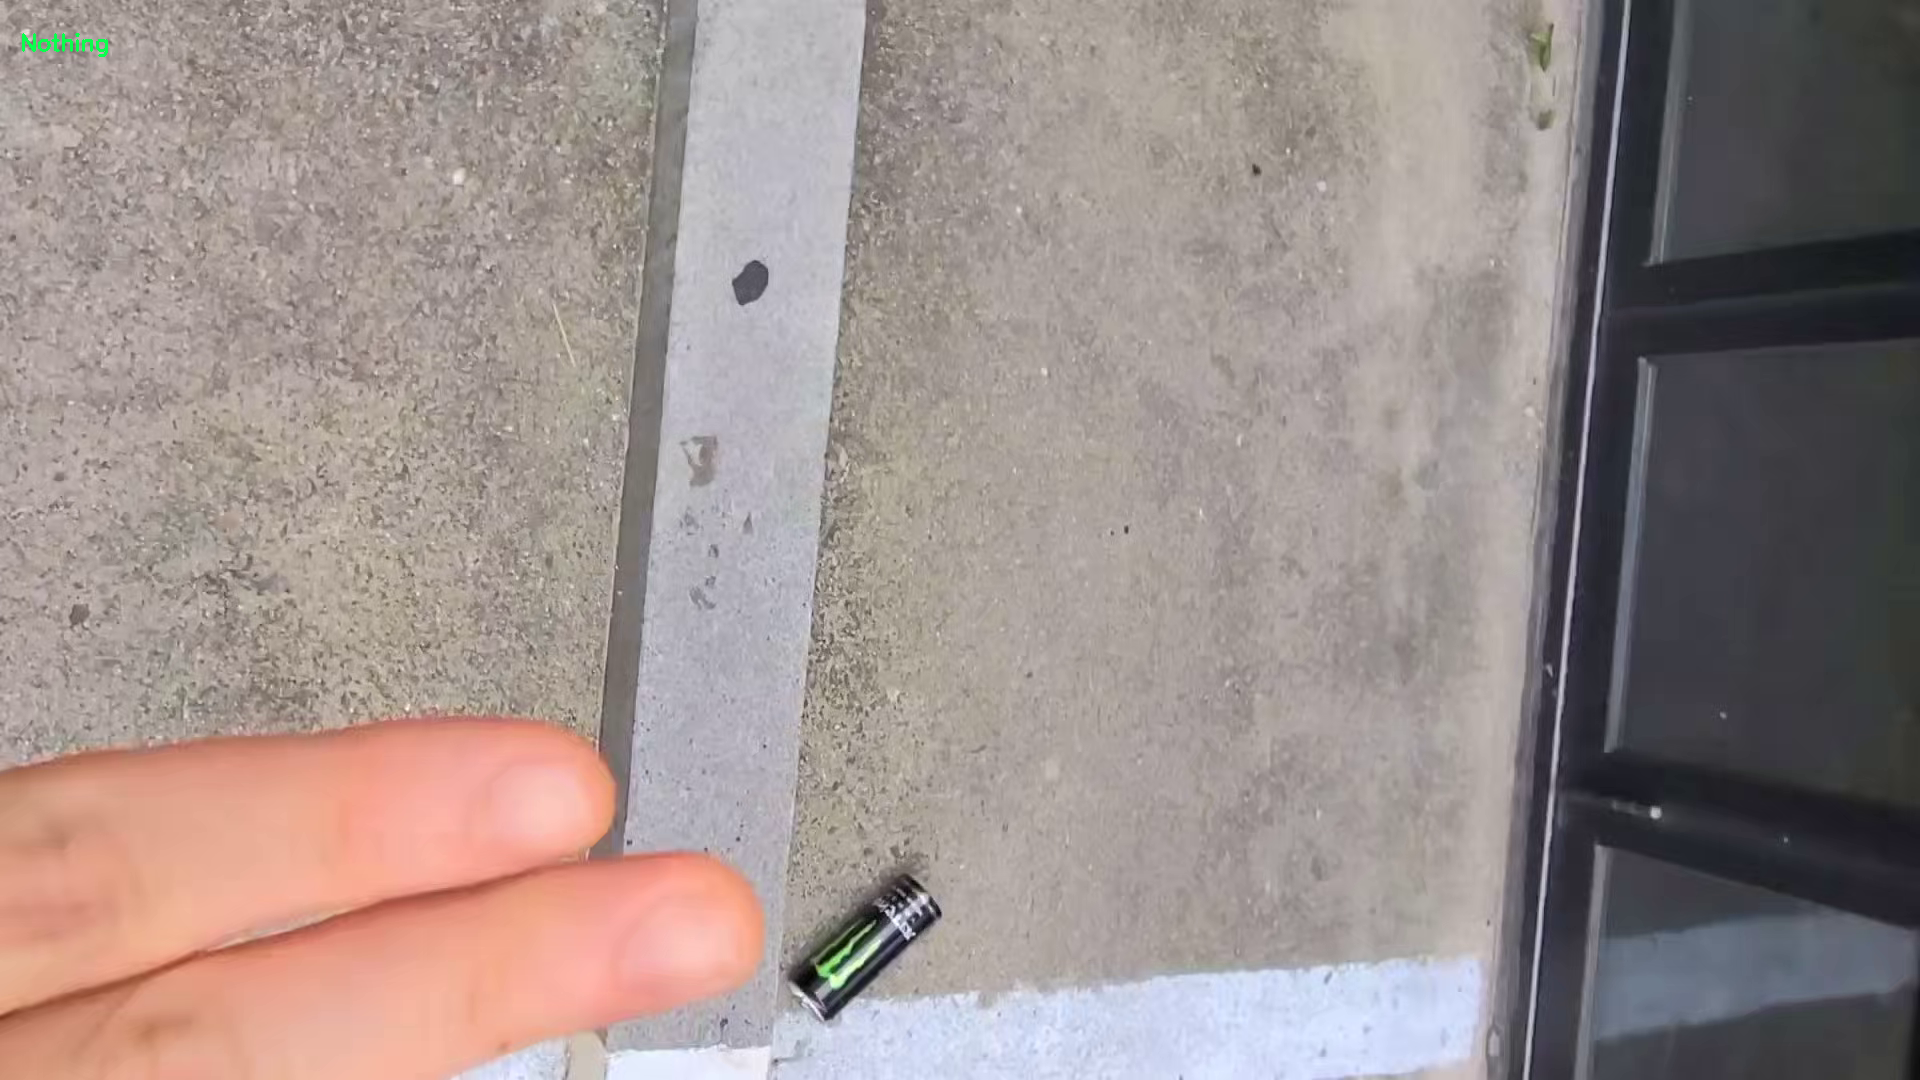

[[570, 841, 803, 1046], [429, 703, 662, 897]]


In [135]:
rectangle_point=[]

args = {
    "model": "/content/frozen_inference_graph.pb",
    # "model":"/media/todd/38714CA0C89E958E/147/yl_tmp/readingbook/model/export_model_015/frozen_inference_graph.pb",
    "labels": "./record/classes.pbtxt",
    # "labels":"record/classes.pbtxt" ,
    "num_classes": 1,
    "min_confidence": 0.6,
    "class_model": "../model/class_model/p_class_model_1552620432_.h5"}

COLORS = np.random.uniform(0, 255, size=(args["num_classes"], 3))

if __name__ == '__main__':
    model = tf.Graph()

    with model.as_default():
        print("> ====== loading NAIL frozen graph into memory")
        graphDef = tf.compat.v1.GraphDef()

        with tf.compat.v2.io.gfile.GFile(args["model"], "rb") as f:
            serializedGraph = f.read()
            graphDef.ParseFromString(serializedGraph)
            tf.import_graph_def(graphDef, name="")
        # sess = tf.Session(graph=graphDef)
        print(">  ====== NAIL Inference graph loaded.")
        # return graphDef, sess

    with model.as_default():
        with tf.compat.v1.Session(graph=model) as sess:
            imageTensor = model.get_tensor_by_name("image_tensor:0")
            boxesTensor = model.get_tensor_by_name("detection_boxes:0")

            # for each bounding box we would like to know the score
            # (i.e., probability) and class label
            scoresTensor = model.get_tensor_by_name("detection_scores:0")
            classesTensor = model.get_tensor_by_name("detection_classes:0")
            numDetections = model.get_tensor_by_name("num_detections:0")
            drawboxes = []
            # cap = cv2.VideoCapture(url)
            #vs = WebcamVideoStream(src=0)
            video="000.mp4"
            vs=cv2.VideoCapture(video)    
            #vs.start()
            for i in range(1):
                ret,frame = vs.read()
                if frame is None:
                    continue
                frame = cv2.flip(frame, 1)
                image = frame
                (H, W) = image.shape[:2]
                # print("H,W:", (H, W))
                output = image.copy()
                img_ff, bin_mask, res = ff.find_hand_old(image.copy())
                image = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
                image = np.expand_dims(image, axis=0)

                (boxes, scores, labels, N) = sess.run(
                    [boxesTensor, scoresTensor, classesTensor, numDetections],
                    feed_dict={imageTensor: image})
                boxes = np.squeeze(boxes)
                scores = np.squeeze(scores)
                labels = np.squeeze(labels)
                boxnum = 0
                box_mid = (0, 0)
                # print("scores_shape:", scores.shape)
                for (box, score, label) in zip(boxes, scores, labels):
                    # print(int(label))
                    # if int(label) != 1:
                    #     continue
                    if score < args["min_confidence"]:
                        continue
                    # scale the bounding box from the range [0, 1] to [W, H]
                    boxnum = boxnum + 1
                    (startY, startX, endY, endX) = box
                    startX = int(startX * W)
                    startY = int(startY * H)
                    endX = int(endX * W)
                    endY = int(endY * H)
                    X_mid = startX + int(abs(endX - startX) / 2)
                    Y_mid = startY + int(abs(endY - startY) / 2)
                    box_mid = (X_mid, Y_mid)
                    # draw the prediction on the output image
                    label_name = 'nail'
                    # idx = int(label["id"]) - 1
                    idx = 0
                    label = "{}: {:.2f}".format(label_name, score)
                    # cv2.rectangle(output, (startX-50, startY-50), (endX+50, endY+50),
                    #               None, 2)
                    # cv2.circle(output,box_mid,50,COLORS[idx],-1)
                    y = startY - 10 if startY - 10 > 10 else startY + 10
                    cv2.putText(output, None, (startX, y),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.3, COLORS[idx], 1)
                    rectangle_point.append([startX-50,startY-50,endX+50,endY+50])
                # show the output image
                # print(boxnum)
                if box_mid == (0, 0):
                    drawboxes.clear()
                    cv2.putText(output, 'Nothing', (20, 50),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.75, (77, 255, 9), 2)
                elif boxnum == 1:
                    drawboxes.append(box_mid)
                    if len(drawboxes) == 1:
                        pp = drawboxes[0]
                        cv2.circle(output, pp, 0, (0, 0, 0), thickness=3)
                        # cv2.line(output, pt1, pt2, (0, 0, 0), 2, 2)
                    if len(drawboxes) > 1:
                        num_p = len(drawboxes)
                        for i in range(1, num_p):
                            pt1 = drawboxes[i - 1]
                            pt2 = drawboxes[i]
                            cv2.circle(output, pp, 0, (0, 0, 0), thickness=3)
                            cv2.line(output, pt1, pt2, (0, 0, 0), 2, 2)
                    cv2.putText(output, 'Point', (20, 50),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.75, (77, 255, 9), 2)
                else:
                    drawboxes.clear()
                    cv2.putText(output, 'Nothing', (20, 50),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.75, (77, 255, 9), 2)
                cv2_imshow(output)
                aa=[]
                aa.append(output)
                print(rectangle_point)
                rectangle_point=[]
                # cv2.waitKey(0)
                if cv2.waitKey(1) & 0xFF == ord("q"):
                    cv2.destroyAllWindows()
                    break

                    # vs.stop()

In [136]:
output

array([[[133, 138, 149],
        [130, 135, 146],
        [135, 140, 151],
        ...,
        [ 50,  55,  55],
        [ 50,  55,  55],
        [ 50,  55,  55]],

       [[161, 166, 177],
        [157, 162, 173],
        [157, 162, 173],
        ...,
        [ 50,  55,  55],
        [ 50,  55,  55],
        [ 50,  55,  55]],

       [[174, 179, 190],
        [172, 177, 188],
        [170, 175, 186],
        ...,
        [ 50,  55,  55],
        [ 50,  55,  55],
        [ 50,  55,  55]],

       ...,

       [[118, 147, 209],
        [118, 147, 209],
        [118, 147, 209],
        ...,
        [ 15,  15,  15],
        [ 16,  16,  16],
        [ 15,  15,  15]],

       [[118, 147, 209],
        [118, 147, 209],
        [119, 148, 210],
        ...,
        [ 15,  15,  15],
        [ 16,  16,  16],
        [ 15,  15,  15]],

       [[118, 147, 209],
        [118, 147, 209],
        [119, 148, 210],
        ...,
        [ 15,  15,  15],
        [ 16,  16,  16],
        [ 15,  15,  15]]

In [137]:
cv2.imwrite('zz.jpg',output)

True

In [138]:
image1 = Image.open('zz.jpg')
croppedImage=image1.crop((570,841,803,1046))

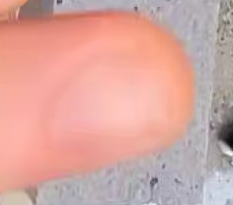

In [139]:
croppedImage

In [147]:
image = cv2.imread('99.png')
gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

contours, hierarchy=cv2.findContours(gray,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
for contour in contours:
  img = cv2.drawContours(image,[contour],-1,(0,0,255),2)


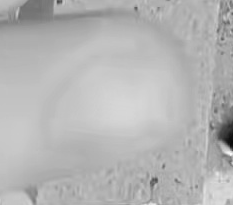

In [149]:
cv2_imshow(gray)

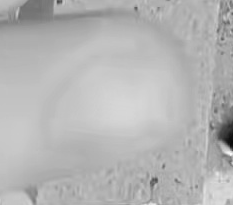

In [144]:
cv2_imshow(gray)

In [140]:
image = cv2.imread('99.png')  # load image

hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)  # BGR to HSV conversion
hsv_img = cv2.resize(hsv_img, (250, 250))

img_s = hsv_img[:, :, 1]  # Extracting Saturation channel on which we will work

img_s_blur = cv2.GaussianBlur(img_s, (7, 7), 0)  # smoothing before applying  threshold

img_s_binary = cv2.threshold(img_s_blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]  # Thresholding to generate binary image (ROI detection)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
img_s_binary = cv2.morphologyEx(img_s_binary, cv2.MORPH_OPEN, kernel, iterations=3)  # reduce some noise

img_croped = cv2.bitwise_and(img_s, img_s_binary) * 2  # ROI only image extraction & contrast enhancement, you can crop this region 

abs_grad_x = cv2.convertScaleAbs(cv2.Sobel(img_croped, cv2.CV_64F, 1, 0, ksize=3))
abs_grad_y = cv2.convertScaleAbs(cv2.Sobel(img_croped, cv2.CV_64F, 0, 1, ksize=3))
grad = cv2.addWeighted(abs_grad_x, .5, abs_grad_y, .5, 0)  # Gradient calculation
grad = cv2.medianBlur(grad, 13)

edges = cv2.threshold(grad, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

cnts = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Contours Detection
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cnt = None
max_area = 0
for c in cnts:
    area = cv2.contourArea(c)
    if area > max_area:  # Filtering contour
        max_area = area
        cnt = c

cv2.drawContours(hsv_img, [cnt], 0, (0, 255, 0), 3)
a=cv2.drawContours(hsv_img, [cnt], 0, (0, 255, 0), 3)
k= cv2.resize(a, dsize=(640, 480), interpolation=cv2.INTER_AREA)

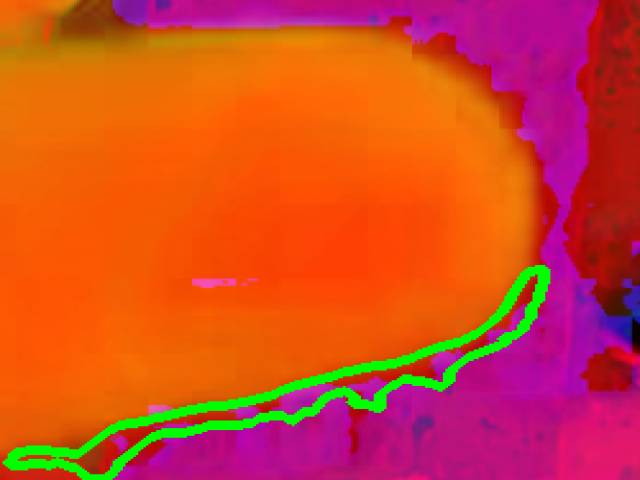

In [141]:
cv2_imshow(k)

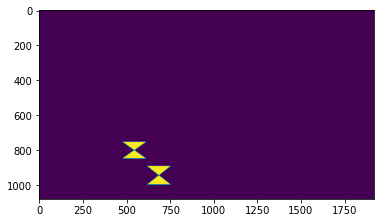

In [71]:
mask1 = np.zeros((1080,1920),dtype = np.uint8)
polygon1 = np.array([[620,891],[753,891],[620,996],[753,996]])
polygon2 = np.array([[479,753],[612,753],[479,847],[612,847]])

cv2.fillPoly(mask1,[polygon1,polygon2],1)
plt.imshow(mask1)

In [54]:
boxes

array([[0.5711501 , 0.43967152, 0.6633598 , 0.5003155 ],
       [0.46368286, 0.3728989 , 0.54662216, 0.4323204 ],
       [0.77301764, 0.41043   , 0.89453316, 0.48984188],
       [0.7605311 , 0.47234574, 0.84048074, 0.5065119 ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        ,

In [38]:
drawboxes.shape

AttributeError: ignored

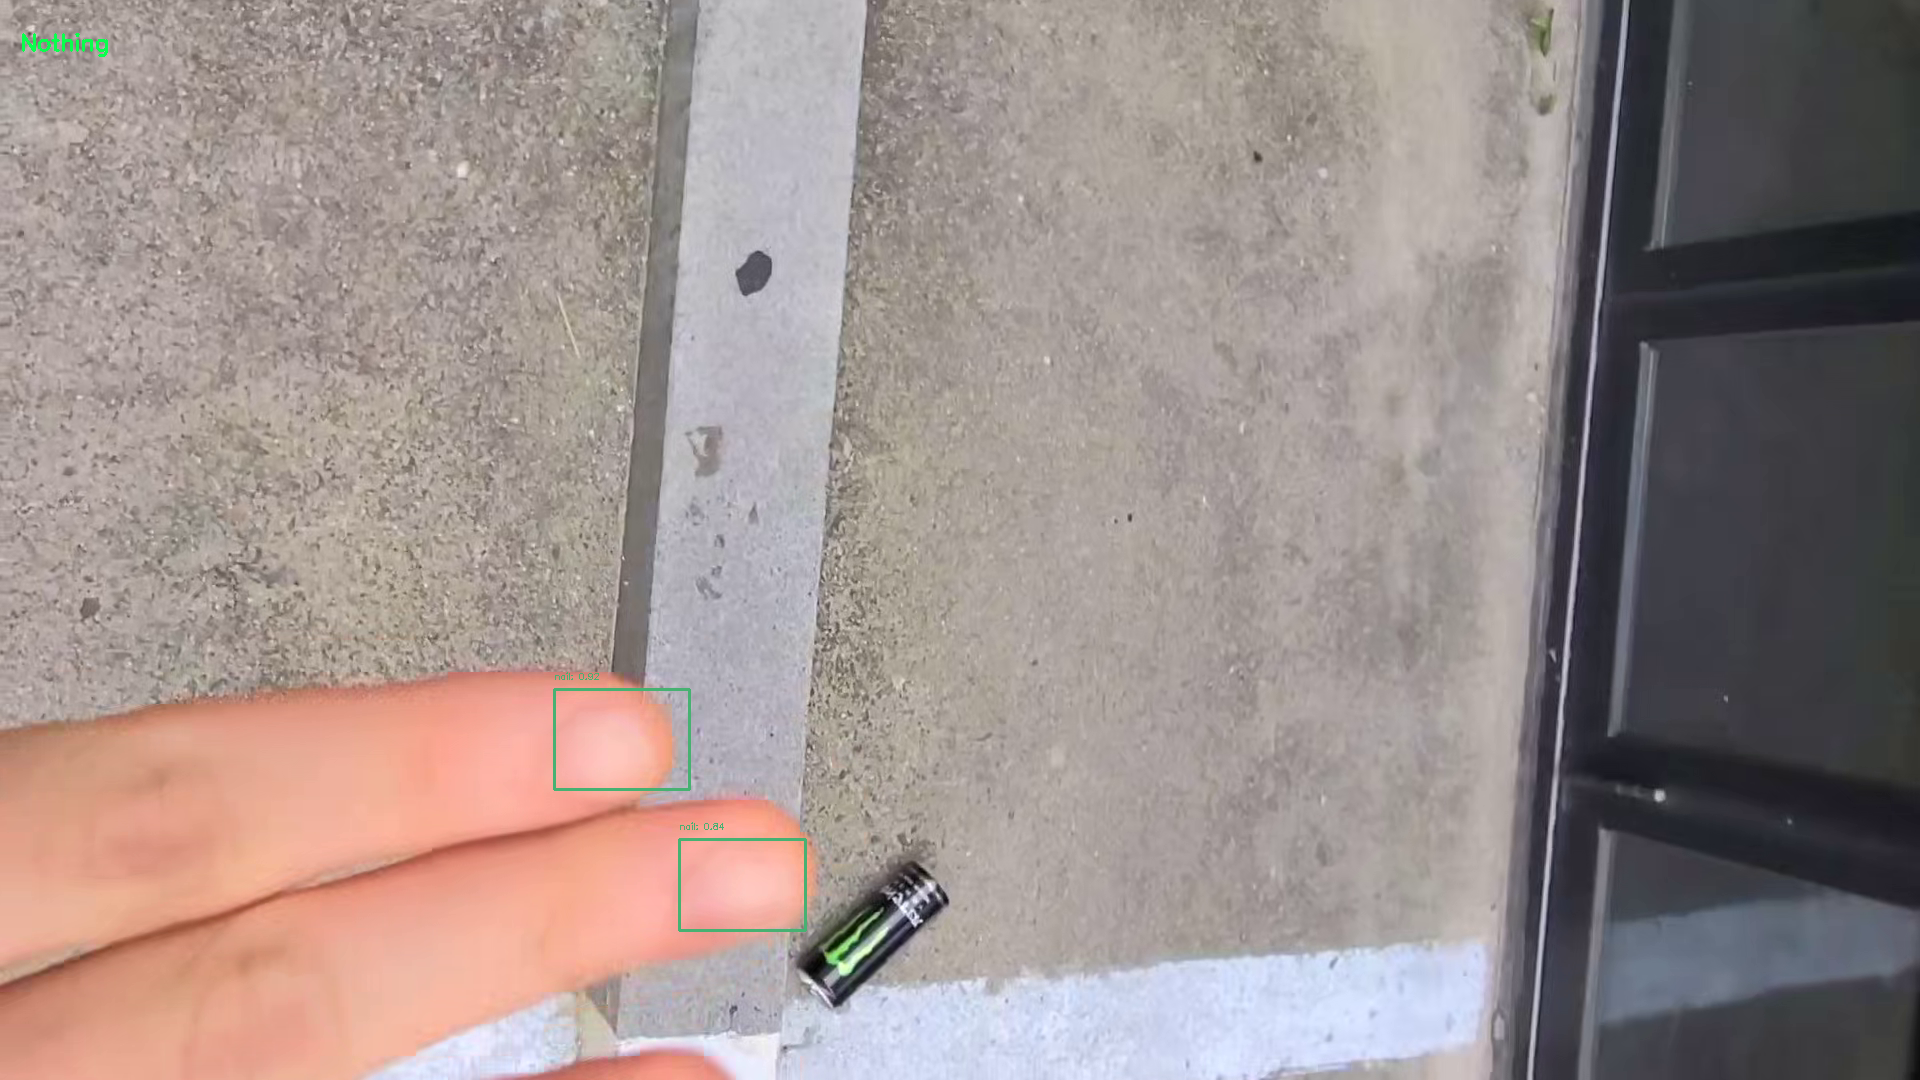

In [35]:
cv2_imshow(k)